In [79]:
using Pkg
Pkg.activate("..");

In [80]:
using OneClassActiveLearning, SVDD
using Unmarshal, JSON, Serialization
using Plots, OCALPlots
using JuMP, Gurobi
using Random
using MLKernels, MLLabelUtils
using LaTeXStrings
using DelimitedFiles, CSV
using DataFrames, StatsFuns

include(joinpath(@__DIR__, "..", "scripts", "subspace_util.jl"))
include(joinpath(@__DIR__, "notebook_util.jl"));

solver = with_optimizer(Gurobi.Optimizer; OutputFlag=0, Threads=1);

In [81]:
experiment_hash = "9478936085490997477"

"9478936085490997477"

In [82]:
result_path = "../data/output/evaluation-part1"
res = getResultFromFile(result_path, experiment_hash)

# rewrite server-side path
res.experiment[:data_file] = ".."* split(res.experiment[:data_file], "..")[end]
data, labels, model = load(res, 50);

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 2.360334150353083e-13. The sum of adjustments is 1.39374430855232e-8
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 2.589040093425865e-13. The sum of adjustments is 1.4776672689218075e-8
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 4.134470543704083e-13. The sum of adjustments is 1.423444590304482e-8
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 2.5579538487363607e-13. The sum of adjustments is 1.0921899139347737e-8
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 2.1049828546892968e-13. The sum of adjustments is 1.0219998391608614e-8
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] 

In [83]:
@show res.experiment[:data_set_name]
@show res.experiment[:model][:fitted][:model_params]

res.experiment[:data_set_name] = "PageBlocks"
((res.experiment[:model])[:fitted])[:model_params] = Dict{Symbol,Any}(:subspaces=>Any[Any[4, 9], Any[1, 10], Any[1, 4], Any[5, 7], Any[6, 8], Any[3, 5], Any[4, 5], Any[1, 8], Any[5, 10], Any[4, 6]],:weight_update_strategy=>Dict(:v_Lin=>10.0,:v_Lout=>0.01),:C=>0.45)


Dict{Symbol,Any} with 3 entries:
  :subspaces              => Any[Any[4, 9], Any[1, 10], Any[1, 4], Any[5, 7], A…
  :weight_update_strategy => Dict(:v_Lin=>10.0,:v_Lout=>0.01)
  :C                      => 0.45

In [84]:
res.experiment[:query_strategy]

Dict{Symbol,Any} with 2 entries:
  :param => Dict{Symbol,Any}(:combination_fct=>"+",:subspaces=>Any[Any[4, 9], A…
  :type  => "SubspaceQs{RandomOutlierPQs}"

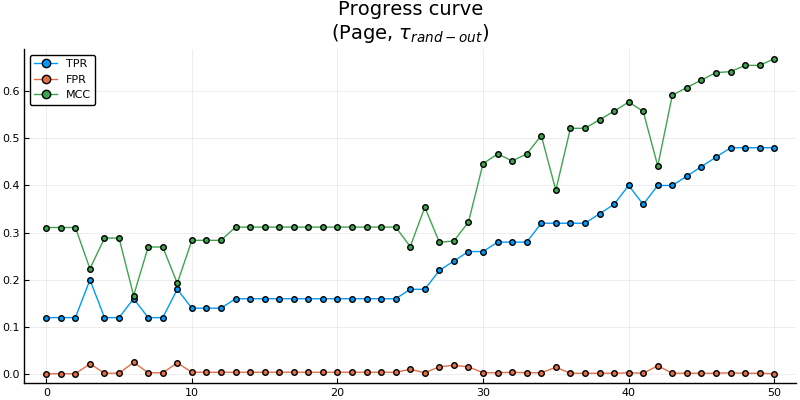

In [85]:
strategy_name = L"\tau_{rand-out}"
plot(res.al_history[:tpr], label="TPR", size = (800, 400))
plot!(res.al_history[:fpr], label="FPR")
plot!(res.al_history[:matthews_corr], label="MCC", title = "Progress curve\n(Page, $strategy_name)")

In [86]:
# map(i -> "$i --> $(MLKernels.getvalue(model.kernel_fct[i].alpha))", eachindex(model.kernel_fct))

Expected time to fit:

In [87]:
extrema(res.al_history[:time_fit].values)

(143.078145073, 173.013144493)

In [88]:
@time SVDD.fit!(model, solver)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
 82.815845 seconds (231.15 M allocations: 16.742 GiB, 51.28% gc time)


OPTIMAL::TerminationStatusCode = 1

In [89]:
predictions = SVDD.predict(model, data)
cm = ConfusionMatrix(SVDD.classify(predictions, Val(:Global)), labels)
cms = ConfusionMatrix.(SVDD.classify(predictions, Val(:Subspace)), fill(labels, length(predictions)));

In [90]:
matthews_corr(cm)

0.6685937061172871

In [91]:
print(cms)

1 --> TP: 16 FP: 0 TN: 950 FN 34 [P = :outlier, N = :inlier]
2 --> TP: 6 FP: 0 TN: 950 FN 44 [P = :outlier, N = :inlier]
3 --> TP: 16 FP: 0 TN: 950 FN 34 [P = :outlier, N = :inlier]
4 --> TP: 12 FP: 0 TN: 950 FN 38 [P = :outlier, N = :inlier]
5 --> TP: 4 FP: 0 TN: 950 FN 46 [P = :outlier, N = :inlier]
6 --> TP: 16 FP: 0 TN: 950 FN 34 [P = :outlier, N = :inlier]
7 --> TP: 20 FP: 0 TN: 950 FN 30 [P = :outlier, N = :inlier]
8 --> TP: 4 FP: 1 TN: 949 FN 46 [P = :outlier, N = :inlier]
9 --> TP: 12 FP: 0 TN: 950 FN 38 [P = :outlier, N = :inlier]
10 --> TP: 13 FP: 0 TN: 950 FN 37 [P = :outlier, N = :inlier]


In [92]:
n_sub = n_outlying_subspaces(predictions)[1:15]

15-element Array{Tuple{Int64,Int64},1}:
 (862, 9)
 (10, 7) 
 (30, 7) 
 (70, 7) 
 (524, 7)
 (150, 6)
 (531, 6)
 (145, 5)
 (167, 5)
 (710, 5)
 (18, 4) 
 (22, 4) 
 (37, 4) 
 (110, 4)
 (285, 4)

In [93]:
observation_id = n_sub[1][1]
outlying_subspaces(observation_id, predictions, model.subspaces)

9-element Array{Array{Int64,1},1}:
 [4, 9] 
 [1, 10]
 [1, 4] 
 [6, 8] 
 [3, 5] 
 [4, 5] 
 [1, 8] 
 [5, 10]
 [4, 6] 

#### Export data

In [94]:
df = DataFrame(predictions, Symbol.(model.subspaces))
CSV.write("single_classification_export/$(experiment_hash)_predictions.csv", df)
subspace_classifications = DataFrame(map(x -> ifelse.(SVDD.classify.(x) .== :outlier, 1, 0), predictions), Symbol.(model.subspaces))
CSV.write("single_classification_export/$(experiment_hash)_classifications.csv", subspace_classifications)

"single_classification_export/9478936085490997477_classifications.csv"

In [95]:
query_history = res.al_history[:query_history].values[1:50];
informativeness = min_max_normalize.(qs_score(DecisionBoundaryPQs(model), data, model.pools, model.subspaces))
query_order = sortperm(reduce(+, informativeness), rev=true);
top_k_queries = [q for q in query_order if !(q in query_history)][1:5];

In [96]:
df = DataFrame([p[top_k_queries] for p in informativeness], Symbol.(model.subspaces))
df[:id] = top_k_queries
CSV.write("single_classification_export/$(experiment_hash)_informativeness.csv", df)

"single_classification_export/9478936085490997477_informativeness.csv"

#### Visualize Subspaces

In [97]:
psize = (1000, 800)
pyplot(size=psize)

Plots.PyPlotBackend()

In [98]:
plots = []
for s_id in eachindex(model.subspaces)
    leg = (s_id == 1) ? :topleft : :none
    push!(plots, Plots.plot(model, labels, s_id , grid_resolution=100, axis_overhang=0.2, legend = leg, grid = false, markersize = 8, seriescolor=:grays, axis=true, size = psize))
end

#### Page Attributes
Original attribute description from https://archive.ics.uci.edu/ml/machine-learning-databases/page-blocks/page-blocks.names

1) height:   integer.         | Height of the block.

2) lenght:   integer.     | Length of the block. 

3) area:     integer.    | Area of the block (height * lenght);

4) eccen:    continuous.  | Eccentricity of the block (lenght / height);

5) p_black:  continuous.  | Percentage of black pixels within the block (blackpix / area);

6) p_and:    continuous.        | Percentage of black pixels after the application of the Run Length Smoothing Algorithm (RLSA) (blackand / area);

7) mean_tr:  continuous.      | Mean number of white-black transitions (blackpix / wb_trans);

8) blackpix: integer.    | Total number of black pixels in the original bitmap of the block.

9) blackand: integer.        | Total number of black pixels in the bitmap of the block after the RLSA.

10) wb_trans: integer.          | Number of white-black transitions in the original bitmap of the block.

In [99]:
att_names = ["height", "length", "area", "eccen", "p_black", "p_and", "mean_tr", "blackpix", "blackand", "wb_trans"];

In [100]:
psize = (450, 250)

(450, 250)

In [101]:
sid = 8
p_8 = plot(model, labels, sid, 
     grid = false, markersize = 8, seriescolor=:grays, title = "", axis=true, size = psize, legend = :topright, 
     xlabel = att_names[model.subspaces[sid][1]], ylabel = att_names[model.subspaces[sid][2]],
     xlims = (-0.1,0.4),
     ylims = (-0.15,1.0),
     tickfontsize = 14,
     guidefontsize = 14,
     legendfontsize = 12,
     ann=[(0.0, -0.07, text(L"id_{402}", :white))]);

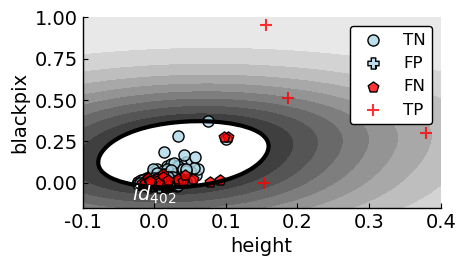

In [102]:
savefig(plot(p_8, title="", markersize = 8), "plots/detailed_result_subspace.pdf")

id 402 is indeed a false positive

In [103]:
data[model.subspaces[sid], 402]

2-element Array{Float64,1}:
  0.007300651863002491
 -0.02813934979197937 

In [104]:
labels[402]

:inlier

In [105]:
SVDD.classify(predictions, Val(:Global))[402]

:outlier

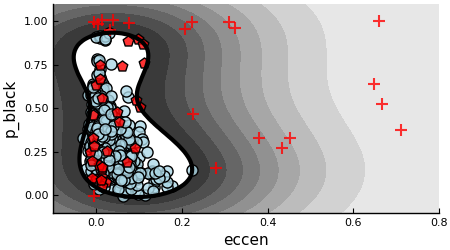

In [106]:
sid = 7
plot(model, labels, sid, 
     grid = false, markersize = 8, seriescolor=:grays, title = "", axis=true, size = psize, legend = :none, 
     xlabel = att_names[model.subspaces[sid][1]], ylabel = att_names[model.subspaces[sid][2]],
     xlims = (-0.1, 0.8),
     ylims = (-0.1,1.1)
)

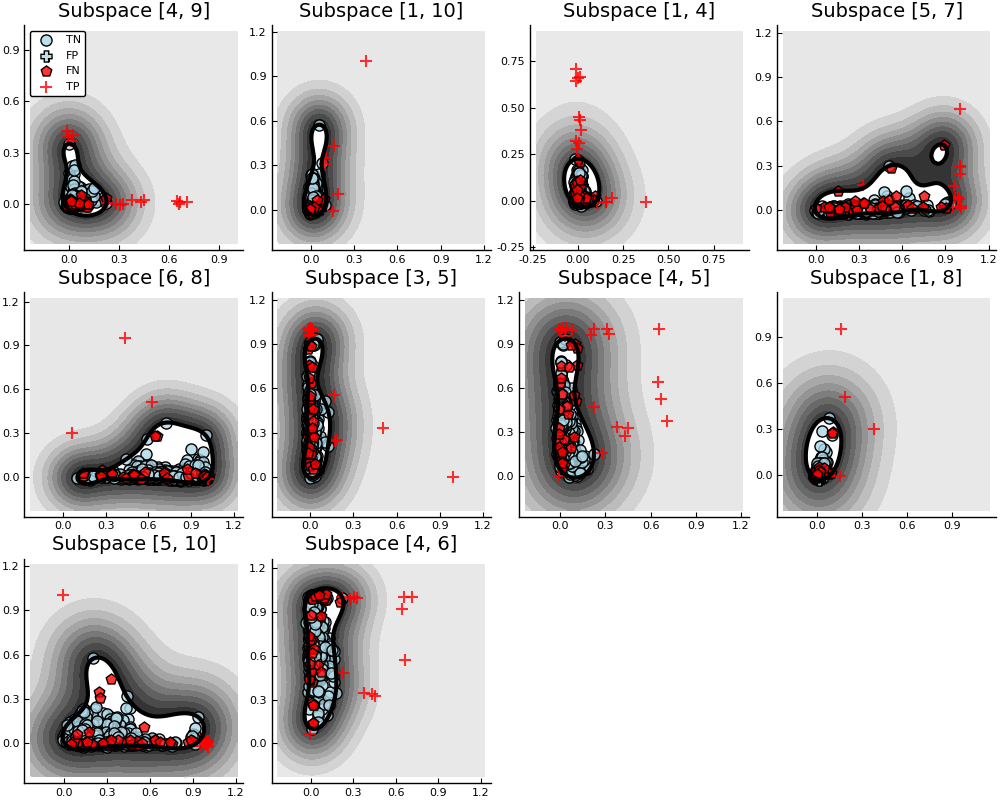

In [107]:
plot(plots..., size=(1000, 800))